In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import warnings; warnings.simplefilter('ignore')
import sys
import h5py
import pandas as pd
import seaborn as sns
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_ancillary
import jsm_visualize
import jsm_SHMR
import jsm_mcmc
from jsm_stellarhalo import Tree_Reader
import jsm_models
import evolve as ev
import galhalo as gh
import profiles as profiles
import config as cfg

In [3]:
plt.style.use('../../../SatGen/notebooks/paper1/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches
levelz = [1-0.99, 1-0.95, 1-0.68]

In [142]:
from treelib import Node, Tree

In [ ]:
class Arborist(Tree_Reader):

    def plant_roots(self):

        self.forest = []
        # for z_ind in range(self.redshift.shape[0] - 1, -1, -1):
        for z_ind in range(self.redshift.shape[0]): #this goes backward in time!

            tree = Tree()

            # Only real subhalos (exclude host -1 and uninitialized -99)
            valid = (self.ParentID[:, z_ind] != -1) & \
                    (self.ParentID[:, z_ind] != -99)

            initialized_subhalos = np.where(valid)[0]

            tree.create_node(
                "Host Halo",
                "0",
                data={
                    "redshift": self.redshift[z_ind],
                    "z_ind": z_ind,
                    "initialized_subhalos": initialized_subhalos,
                    "mass": self.mass[0, z_ind],
                    })

            self.forest.append(tree)

    # -----------------------------------------------------

    def add_branch(self, tree, subhalo_ind, z_ind):

        node_id = str(subhalo_ind)
        parent_ind = self.ParentID[subhalo_ind, z_ind]

        if parent_ind == -99:
            return  # parent uninitialized, abandon this branch

        parent_id = str(parent_ind)

        if not tree.contains(parent_id):
            self.add_branch(tree, parent_ind, z_ind)

        # Parent still missing after recursion means it was abandoned — skip
        if not tree.contains(parent_id):
            return

        if not tree.contains(node_id):
            tree.create_node(
                f"subID:{node_id}",
                node_id,
                parent=parent_id,
                data={
                    "mass": self.mass[subhalo_ind, z_ind],
                    "concentration": self.concentration[subhalo_ind, z_ind],
                    "rvir": self.VirialRadius[subhalo_ind, z_ind],
                    })

    # -----------------------------------------------------

    def water_roots(self):

        for tree in self.forest:

            root = tree.get_node("0")
            z_ind = root.data["z_ind"]
            initialized_subhalos = root.data["initialized_subhalos"]

            for subhalo_ind in initialized_subhalos:
                self.add_branch(tree, subhalo_ind, z_ind)

    # -----------------------------------------------------

    def dendrochronology(self, mass_threshold):

        self.NAH = np.array([tree.size() - 1 for tree in self.forest])
        n_snapshots = len(self.forest)

        self.kmax = np.max(self.order)
        self.dendo_mat = np.zeros((n_snapshots, self.kmax), dtype=int)

        self.NAH_thresh = np.zeros(len(self.forest), dtype=int)

        for t, tree in enumerate(self.forest):
            self.NAH_thresh[t] = sum(1 for node in tree.all_nodes() if node.identifier != "0" and node.data["mass"] >= mass_threshold)
            for k in range(1, self.kmax + 1):
                self.dendo_mat[t, k-1] = tree.size(level=k)

    def canopy(self, mass_threshold):

        #within Virial Radius
        self.within_Rvir = self.rmags_stitched[1:, 0] < self.VirialRadius[0,0]

        #the artificial disruption criteia
        self.artdisrupt_mass = jsm_ancillary.artificial_disruption(self.acc_mass[1:], self.acc_concentration[1:])
        self.artdisrupt_mask = self.mass[1:, 0] > self.artdisrupt_mass #does not artificially disrupt

        #all subhalos above an arbitrary mass limit
        self.mass_cut = self.mass[1:, 0] > mass_threshold
        #most conservative
        self.N_artcut = np.sum(self.mass_cut & self.within_Rvir & self.artdisrupt_mask)
        #somewhere in the middle
        self.N_Rvircut = np.sum(self.mass_cut & self.within_Rvir)
        #most lax
        self.N_cut = np.sum(self.mass_cut)

In [238]:
# class Arborist(Tree_Reader):

#     def plant_roots(self):

#         self.forest = []
        
#         for z_ind in range(self.redshift.shape[0]-1, -1, -1): # this goes forwards in time!

#             tree = Tree()

#             valid = (self.ParentID[:, z_ind] != -1) & \
#                     (self.ParentID[:, z_ind] != -99)

#             initialized_subhalos = np.where(valid)[0]

#             tree.create_node("Host Halo", "0", data={"redshift": self.redshift[z_ind],
#                                                     "z_ind": z_ind,
#                                                     "initialized_subhalos": initialized_subhalos,
#                                                     "mass": self.mass[0, z_ind]})
#             self.forest.append(tree)
    
#     def add_branch(self, tree, subhalo_ind, z_ind):
#         node_id = str(subhalo_ind)
#         parent_id = str(self.ParentID[subhalo_ind, z_ind])
        
#         # If parent not yet in tree, add it (or recurse)
#         if not tree.contains(parent_id):
#             # Recursively ensure the parent is added first
#             self.add_branch(tree, int(parent_id), z_ind)
#             # If parent still not in tree after recursion, skip this node
#             if not tree.contains(parent_id):
#                 return
#         # Finally add the current node (if not already added)
#         if not tree.contains(node_id):
#             tree.create_node("subID:" + node_id, node_id, parent=parent_id, data={"mass":self.mass[subhalo_ind, z_ind],
#                                                                                 "concentration":self.concentration[subhalo_ind, z_ind],
#                                                                                 "rvir":self.VirialRadius[subhalo_ind, z_ind]})
#     def water_roots(self):

#         for tree in self.forest:

#             initialized_subhalos = tree.get_node("0").data["initialized_subhalos"]
#             z_ind = tree.get_node("0").data["z_ind"]

#             for subhalo_ind in initialized_subhalos:
#                 self.add_branch(tree, subhalo_ind, z_ind)

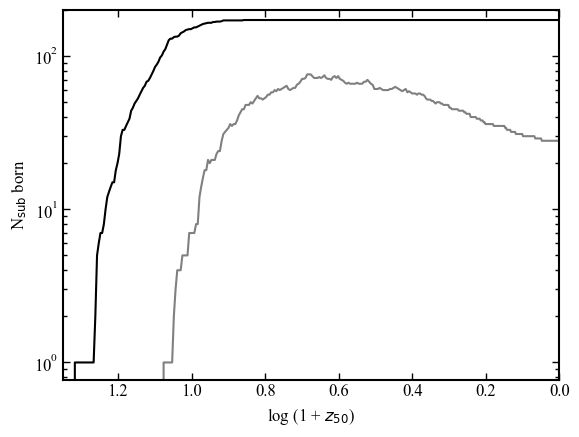

In [239]:
early = Arborist(file="../../../StellarHalo/data/four_examples/DF/early_evo.npz", verbose=False)
early.plant_roots()
early.water_roots()
early.dendrochronology(mass_threshold=1e9)
early.canopy(mass_threshold=1e9)

plt.plot(np.log10(1+cfg.zsample), early.NAH, color="k")
plt.plot(np.log10(1+cfg.zsample), early.NAH_thresh, color="grey")

# plt.plot(np.log10(1+cfg.zsample), early.dendo_mat[:, 0], ls="--")
# plt.plot(np.log10(1+cfg.zsample), early.dendo_mat[:, 1], ls="--")
# plt.plot(np.log10(1+cfg.zsample), early.dendo_mat[:, 2], ls="--")

plt.yscale("log")
plt.xlim(1.35, 0.0)
plt.ylabel("N$_{\\rm sub}$ born")
plt.xlabel("log (1 + $z_{50}$)")

plt.ylim(0, 200)
plt.show()

In [242]:
early.N_Rvircut

16

In [232]:
early.rmags_stitched[:, 0]

array([   0.        ,  243.89958102,  201.65275152,  246.31197194,
        373.15742177,  245.69818792,  257.16505454,  241.28844212,
        233.40061504,  393.24698073,  287.43078854,  417.47375121,
        286.31157204,  366.11997401,   62.34577891,  122.11224669,
        800.04746845,  233.03215349,  663.40546211,   93.07346953,
        146.72535413,  137.43088937,  139.02539749,  121.49403882,
        187.72399197,   38.19001115,  146.90920183,  391.76167562,
       1197.49176786,  111.74510892,  382.26899783,  176.82584589,
                 nan,  102.42785546,           nan,  994.9151528 ,
         61.35957437,   62.06196316,           nan,           nan,
        127.97538142,   43.2165703 ,           nan,           nan,
         57.0667548 ,  288.32554838,   75.50709017,   36.32434143,
                 nan,   98.44301018,           nan,           nan,
         72.16726637,   41.07650147,   18.34350885,  105.41163135,
                 nan,           nan,   43.49179419,           

In [231]:
early.mass[:, 0] > 1e9

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

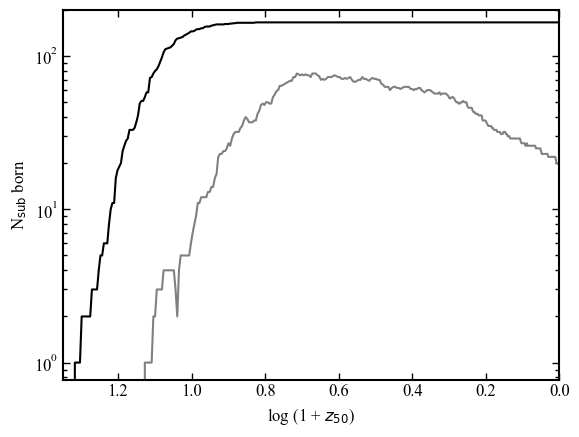

In [215]:
middle = Arborist(file="../../../StellarHalo/data/four_examples/DF/middle_evo.npz", verbose=False)
middle.plant_roots()
middle.water_roots()
middle.dendrochronology(mass_threshold=1e9)

plt.plot(np.log10(1+cfg.zsample), middle.NAH, color="k")
plt.plot(np.log10(1+cfg.zsample), middle.NAH_thresh, color="grey")

# plt.plot(np.log10(1+cfg.zsample), middle.dendo_mat[:, 0], ls="--")
# plt.plot(np.log10(1+cfg.zsample), middle.dendo_mat[:, 1], ls="--")
# plt.plot(np.log10(1+cfg.zsample), middle.dendo_mat[:, 2], ls="--")

plt.yscale("log")
plt.xlim(1.35, 0.0)
plt.ylabel("N$_{\\rm sub}$ born")
plt.xlabel("log (1 + $z_{50}$)")

plt.ylim(0, 200)
plt.show()

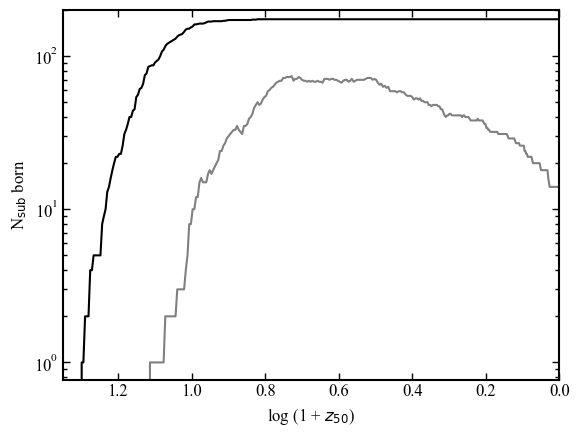

In [216]:
late = Arborist(file="../../../StellarHalo/data/four_examples/DF/late_evo.npz", verbose=False)
late.plant_roots()
late.water_roots()
late.dendrochronology(mass_threshold=1e9)

plt.plot(np.log10(1+cfg.zsample), late.NAH, color="k")
plt.plot(np.log10(1+cfg.zsample), late.NAH_thresh, color="grey")

# plt.plot(np.log10(1+cfg.zsample), late.dendo_mat[:, 0], ls="--")
# plt.plot(np.log10(1+cfg.zsample), late.dendo_mat[:, 1], ls="--")
# plt.plot(np.log10(1+cfg.zsample), late.dendo_mat[:, 2], ls="--")

plt.yscale("log")
plt.xlim(1.35, 0.0)
plt.ylabel("N$_{\\rm sub}$ born")
plt.xlabel("log (1 + $z_{50}$)")

plt.ylim(0, 200)
plt.show()

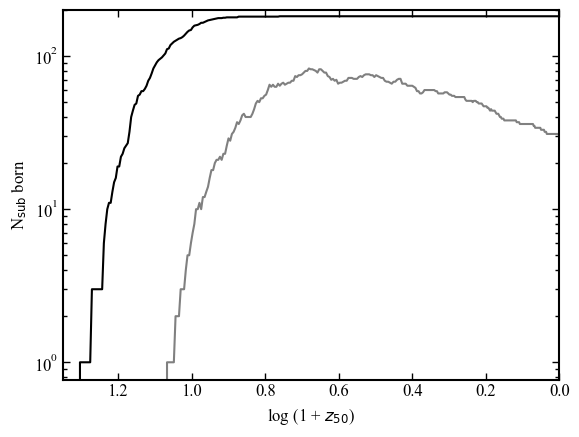

In [217]:
latest = Arborist(file="../../../StellarHalo/data/four_examples/DF/latest_evo.npz", verbose=False)
latest.plant_roots()
latest.water_roots()
latest.dendrochronology(mass_threshold=1e9)

plt.plot(np.log10(1+cfg.zsample), latest.NAH, color="k")
plt.plot(np.log10(1+cfg.zsample), latest.NAH_thresh, color="grey")

# plt.plot(np.log10(1+cfg.zsample), latest.dendo_mat[:, 0], ls="--")
# plt.plot(np.log10(1+cfg.zsample), latest.dendo_mat[:, 1], ls="--")
# plt.plot(np.log10(1+cfg.zsample), latest.dendo_mat[:, 2], ls="--")

plt.yscale("log")
plt.xlim(1.35, 0.0)
plt.ylabel("N$_{\\rm sub}$ born")
plt.xlabel("log (1 + $z_{50}$)")

plt.ylim(0, 200)
plt.show()

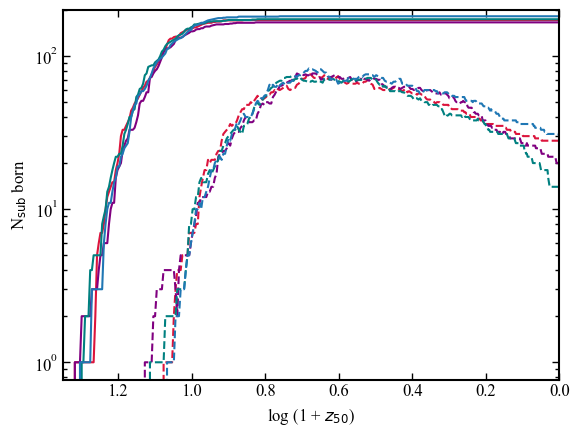

In [220]:
plt.plot(np.log10(1+cfg.zsample), early.NAH, color="crimson")
plt.plot(np.log10(1+cfg.zsample), early.NAH_thresh, color="crimson", ls="--")

plt.plot(np.log10(1+cfg.zsample), middle.NAH, color="purple")
plt.plot(np.log10(1+cfg.zsample), middle.NAH_thresh, color="purple", ls="--")

plt.plot(np.log10(1+cfg.zsample), late.NAH, color="teal")
plt.plot(np.log10(1+cfg.zsample), late.NAH_thresh, color="teal", ls="--")

plt.plot(np.log10(1+cfg.zsample), latest.NAH, color="C0")
plt.plot(np.log10(1+cfg.zsample), latest.NAH_thresh, color="C0", ls="--")

plt.yscale("log")
plt.xlim(1.35, 0.0)
plt.ylabel("N$_{\\rm sub}$ born")
plt.xlabel("log (1 + $z_{50}$)")

plt.ylim(0, 200)
plt.show()